In [37]:
import sys
sys.path.insert(1, '..')
from utils import *
from netsmile import *
import altair as alt
import seaborn as sns

alt.data_transformers.disable_max_rows()

%matplotlib inline

In [38]:
with open(join('..', '..', 'config.yml')) as f:
    config = yaml.safe_load(f)
    
pwd = config['pwd']
dpath = config['storage']
patterns = config['pattern-data-path']
util_datasets = config['util_datasets']
datasets = config['datasets']
colors = config['colors']

FIG_SAVE_DIR = join(pwd, 'figures')
RESULT_SAVE_DIR = join(pwd, 'results')

AREA_NAME = 'NYC'

In [39]:
cbg_poi = pd.read_csv(join(pwd, util_datasets, 'nyc-cbg-poi-info.csv'))
cbg_spread_rank = pd.read_csv(join(pwd, util_datasets, 'nyc_spreader_rank.csv'))
cbg_case_rank = pd.read_csv(join(pwd, util_datasets, 'nyc_case_rank.csv'))
cbg_case_rank.columns = ['cbg', 'cases-avg-rank']

msa_counties = pd.read_csv(join(pwd, util_datasets, AREA_NAME, datasets['nyc-msa']))['fips'].astype(np.int64)
census_data = join(pwd, util_datasets, datasets['census-data'])
census_quartiles, census_raw = get_census_attributes(census_data, msa_counties)

In [40]:
nyc_geojson = join(pwd, util_datasets, AREA_NAME, datasets['nyc-shapefile'])
base_df = gpd.read_file(nyc_geojson)
base_df = base_df.to_crs({'proj':'cea'})
base_df = base_df[base_df.BLKGRPCE != '0']
base_df['km2'] = base_df.area/10**6
base_df = base_df[['GEOID', 'km2']]
base_df['GEOID'] = base_df['GEOID'].astype(np.int64)

In [41]:
df = pd.merge(cbg_poi, cbg_case_rank, left_on='census_tract', right_on='cbg', how='inner').drop('census_tract', axis=1)
df = pd.merge(df, census_raw, left_on='cbg', right_on='census_block_group', how='inner').drop('census_block_group', axis=1)
df = pd.merge(df, base_df, left_on='cbg', right_on='GEOID', how='inner').drop('GEOID', axis=1)

In [42]:
df['poi_density'] = df['poi_count'] / df['km2']

In [43]:
fp2name = {
    '36081': 'Queens',
    '36005': 'Bronx',
    '36085': 'Staten Island',
    '36061': 'Manhattan',
    '36047': 'Brooklyn' 
}

In [44]:
codes = {fips: ind for ind, fips in enumerate(df.cbg.astype(str).str[:5].unique())}
df['borough'] = df.cbg.astype(str).str[:5].apply(lambda x: codes[x])
df['borough_name'] = df.cbg.astype(str).str[:5].apply(lambda x: fp2name[x])

In [50]:
alt.Chart(df).mark_circle(fillOpacity=0.6).encode(
    x=alt.X('cases-avg-rank', title='Spreader Rank'),
    y=alt.Y('poi_density', scale=alt.Scale(type='log'), title='POI Density (log scale)'),
    color=alt.Color('borough_name', title='Borough')
).facet(
    facet='borough_name:N',
    columns=3
)

alt.FacetChart(...)

In [53]:
filtered_df = df[df['borough_name'] != 'Staten Island']
#filtered_df = df

feature_names = ['poi_density', 'poi_diversity', 'income', 'white_population',
                 'black_population', 'hispanic_population', 'population']

vec = filtered_df[feature_names]
vec = pd.DataFrame(stats.zscore(vec.values, nan_policy='omit'), columns=feature_names)
y = pd.Series(stats.zscore(filtered_df['cases-avg-rank'].values, nan_policy='omit'), name='Avg Case Rank - Except Staten Island')
X = sm.add_constant(vec)
result = sm.OLS(y, X, missing='drop').fit()

# with open(join(reg_dir, 'nane.txt'), 'w') as f:
#     f.write(result.summary().as_text())
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     OLS Regression Results                                     
================================================================================================
Dep. Variable:     Avg Case Rank - Except Staten Island   R-squared:                       0.626
Model:                                              OLS   Adj. R-squared:                  0.626
Method:                                   Least Squares   F-statistic:                     1232.
Date:                                  Wed, 09 Mar 2022   Prob (F-statistic):               0.00
Time:                                          20:33:45   Log-Likelihood:                -4707.5
No. Observations:                                  5161   AIC:                             9431.
Df Residuals:                                      5153   BIC:                             9483.
Df Model:                                             7                                         
Covariance Type:                              nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0108      0.008      1.280      0.200      -0.006       0.027
poi_density            -0.0894      0.011     -8.149      0.000      -0.111      -0.068
poi_diversity           0.0229      0.011      2.164      0.031       0.002       0.044
income                 -0.2897      0.011    -27.054      0.000      -0.311      -0.269
white_population       -0.0495      0.014     -3.433      0.001      -0.078      -0.021
black_population       -0.1434      0.013    -10.779      0.000      -0.169      -0.117
hispanic_population     0.1165      0.011     11.017      0.000       0.096       0.137
population              0.6278      0.009     71.598      0.000       0.611       0.645
==============================================================================
Omnibus:                      727.246   Durbin-Watson:                   1.346
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4538.736
Skew:                          -0.513   Prob(JB):                         0.00
Kurtosis:                       7.478   Cond. No.                         3.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

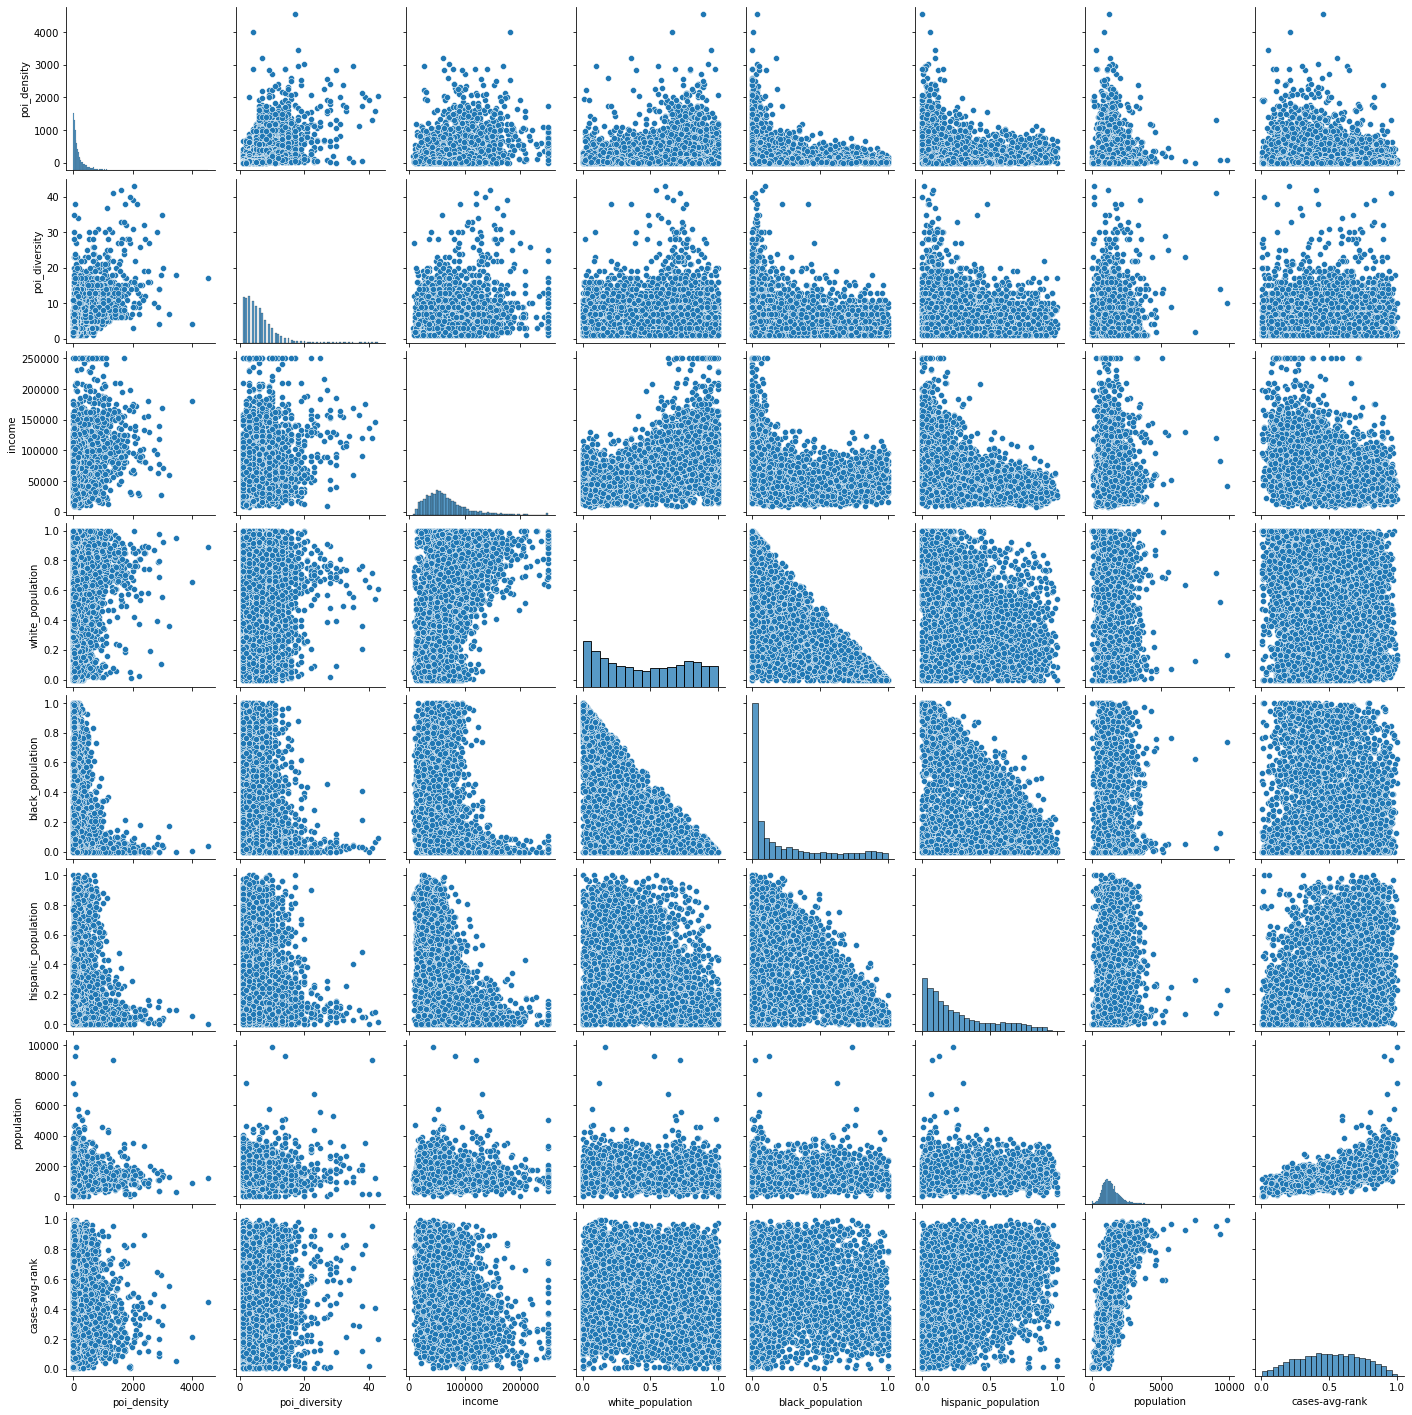

In [58]:
#filtered_df = df[df['borough_name'] != 'Staten Island']
filtered_df = df

sns.pairplot(filtered_df[feature_names + ['cases-avg-rank']])
plt.savefig(join(FIG_SAVE_DIR, 'all-cbgs-cases-pairs.png'))